# CONTROL LIBRARY EXAMPLES

# Preliminaries

In [1]:
from controlSBML.control_extensions.state_space_tf import StateSpaceTF
import controlSBML as ctl

import control
import numpy as np
import pandas as pd
import sympy
import tellurium as te
import matplotlib.pyplot as plt

# Antimony Models

## LINEAR_MDL

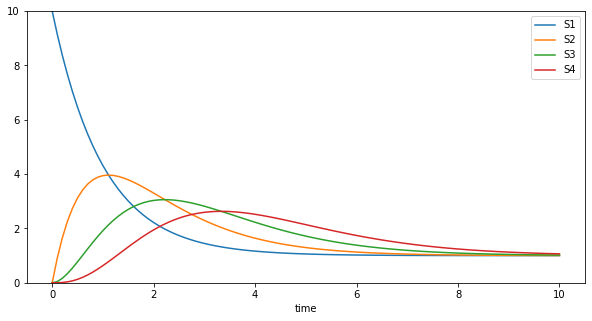

In [2]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
LINEAR_MDL = """
J0:  -> S1; E_J0
J1: S1 -> S2; k1*S1*E_J1
J2: S2 -> S3; k2*S2*E_J2
J3: S3 -> S4; k3*S3*E_J3
J4: S4 -> $S5; k4*S4*E_J4

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
S5 = 0
E_J0 = 1
E_J1 = 1
E_J2 = 1
E_J3 = 1
E_J4 = 1
"""

LINEAR_CTL = ctl.ControlSBML(LINEAR_MDL, input_names=["J0"], output_names=["S4", "S1"])
LINEAR_CTL.plotTrueModel(figsize=(10, 5), end_time=10)

## NONLINEAR_MDL

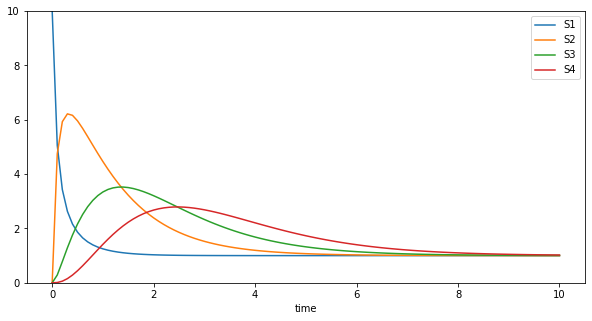

In [3]:
# Nonlinear model with one quadratic term
NONLINEAR_MDL = """
J0: -> S1; k1*E_J0
J1: S1 -> S2; k2*S1*S1
J2: S2 -> S3; k3*S2
J3: S3 -> S4; k3*S3
J4: S4 -> $S5; k4*S4

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
E_J0 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
S5 = 2
"""

NONLINEAR_CTL = ctl.ControlSBML(NONLINEAR_MDL, output_names=["S1", "S4"], input_names=["J0"])
NONLINEAR_CTL.plotTrueModel(figsize=(10, 5), end_time=10, ylim=[0, 10])

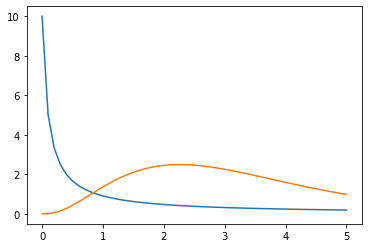

In [4]:
nonlinear_sys = NONLINEAR_CTL.makeNonlinearIOSystem("nonlinear", effector_dct={"J0": "E_J0"})
times = [0.1*n for n in range(0, 51)]
NONLINEAR_CTL.setTime(0)
result = control.input_output_response(nonlinear_sys, times, X0=NONLINEAR_CTL.state_ser.values)
df = pd.DataFrame(np.transpose(result.outputs), columns = NONLINEAR_CTL.output_names)
_ = plt.plot(result.t, df)

# Simulation Effectors

In [5]:
length = 100
dt = 0.1
rr = LINEAR_CTL.roadrunner
rr.reset()
datas = []
for idx in range(length):
    err = 5.75 - rr["S1"]
    rr["E_J0"] += max(0, 2*err)
    #print((rr["S1"], err, rr["E_J0"], rr["J1"]))
    data = rr.simulate(idx*dt, (idx+1)*dt, 2)
    datas.append(data[0, :])
df = pd.DataFrame(np.array(datas))
df.columns = ["time", "S1", "S2", "S3", "S4"]
df = df.set_index("time")
df

,S1,S2,S3,S4
time,,,,
0.0,10.000000,0.000000,0.000000,0.000000
0.1,9.143537,0.909516,0.045397,0.001512
0.2,8.368577,1.654985,0.164895,0.010973
0.3,7.667364,2.259391,0.336968,0.033603
0.4,7.032881,2.742832,0.544182,0.072277
...,...,...,...,...
9.5,9.095488,9.087263,9.051590,8.946985
9.6,9.095579,9.088049,9.055019,8.957096
9.7,9.095661,9.088769,9.058193,8.966558


# Constructing a Cascade of Systems

Notes
1. First create a ``NonlinearIOSystem``. Simulation is done via ``input_output_response``.
1. Eacn system, system input, system output, and system state must have a name.
1. Connections between systems are done by name
1. If there is more than one input, then you must specify the input for all time steps.
1. The number of states in the combined system is the sum of the number of states in each component system.
1. WHen specifying connections, give the input signal and then the outputs.

## Simple, Synthetic System

In [6]:
NUM_STATE = 3
END_TIME = 10
# Create a simple system
def generateRandomState(time, x_vec, u_vec, params=None):
    num_state = len(x_vec)
    new_state = np.random.rand(num_state)
    new_state *= u_vec
    return new_state
#
state_names = ["s%d" % n for n in range(NUM_STATE)]
input_names = ["u%d" % n for n in range(NUM_STATE)]
out_sys = control.NonlinearIOSystem(generateRandomState, None, states=state_names,
                                             inputs=input_names, outputs=state_names, name="out_sys")
inp_sys = control.NonlinearIOSystem(generateRandomState, None, states=state_names,
                                             inputs=input_names, outputs=state_names, name="inp_sys")

In [7]:
X0 = [np.random.rand(1) for _ in range(NUM_STATE)]
u_vec = np.array([np.array(np.random.rand(NUM_STATE)) for _ in  range(END_TIME)])
u_vec = np.array([np.repeat(100, NUM_STATE) for _ in  range(END_TIME)])
u_vec = np.transpose(u_vec)
times = np.array([n*0.1 for n in range(END_TIME)])
t, y = control.input_output_response(inp_sys, times, u_vec, X0)

In [8]:
io_serial = control.interconnect(
  [inp_sys, out_sys],
  connections=[
    ['out_sys.u0', 'inp_sys.s0'],
      ['out_sys.u1', 'inp_sys.s1'],
      ['out_sys.u2', 'inp_sys.s2'],
  ],
  inplist=['inp_sys.u1', 'inp_sys.u2', 'inp_sys.u0'],
  outlist=['out_sys.s1', 'out_sys.s2', 'out_sys.s0'],
)

In [9]:
io_serial.nstates, io_serial.noutputs, io_serial.ninputs

(6, 3, 3)

In [10]:
num_state = 2*NUM_STATE
X0 = [np.random.rand(1) for _ in range(num_state)]
u_vec = np.array([np.repeat(1000, NUM_STATE) for _ in  range(END_TIME)])
u_vec = np.transpose(u_vec)
times = np.array([n*0.1 for n in range(END_TIME)])
t, y = control.input_output_response(io_serial, times, u_vec, X0)

In [11]:
y

array([[  0.82922537,   2.18195419,   5.90474182,  12.00052293,
         22.10145422,  33.40448455,  48.38767024,  64.35418133,
         82.45840714, 102.6802236 ],
       [  0.94011294,   2.099622  ,   6.39260856,  11.98082604,
         19.74071681,  30.58274083,  44.36124499,  63.42370361,
         82.83035997, 101.8390174 ],
       [  0.12971092,   1.5002206 ,   5.94047201,  12.34745719,
         19.60485331,  30.33585838,  47.66476255,  66.3943658 ,
         88.46972839, 114.16729013]])

In [12]:
io_serial = control.interconnect(
  [tellurium, inp_sys],
  connections=[
  ['tellurium.J0', 'inp_sys.out'],
  ],
  inplist=['inp_sys.inp'],
  outlist=ctlsb.output_names,
)

NameError: name 'tellurium' is not defined

In [ ]:
io_serial.connections

In [ ]:
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, input_names=["J0"], output_names=["S1", "S2"])
effector_dct = {"J0": "E_J0"}
params = {"ctlsb": ctlsb, "effector_dct": effector_dct}
num_state = 1 + ctlsb.num_state
X0 = [np.random.rand(1) for _ in range(num_state)]
u_vec = np.array([1000 for _ in  range(END_TIME)])
u_vec = np.transpose(u_vec)
times = np.array([n*0.1 for n in range(END_TIME)])
t, y = control.input_output_response(io_serial, times, u_vec, X0, params=params)
df = pd.DataFrame(y, columns=ctlsb.output_names)

In [ ]:
y

In [ ]:
df = pd.DataFrame(y, index=ctlsb.output_names).T
df

# Controller Construction

## Uncontrolled System

In [22]:
nonlinear_sys = NONLINEAR_CTL.makeNonlinearIOSystem("nonlinear", effector_dct={"J0": "E_J0"})

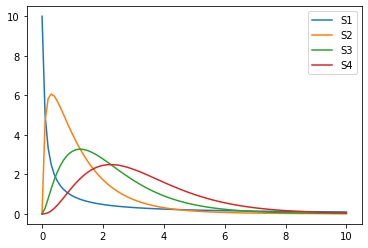

In [23]:
# Uncontrolled system
X0 = nonlinear_sys.getStateSer().values
result = control.input_output_response(nonlinear_sys, times, X0=X0)
df = pd.DataFrame(np.transpose(result.states), columns=nonlinear_sys.state_names)
_ = plt.plot(result.t, df)
plt.legend(df.columns)

## Regulating S1

In [24]:
xeq = [20]
global cum_err
cum_err = 0
def outfcn(t, x, u, _):
    global cum_err
    err = xeq - u
    cum_err += err
    control_error = 30*err + cum_err 
    control_error = min(control_error, 25)
    return control_error
controller = control.NonlinearIOSystem(
  None,
  outfcn,
  inputs=['in'],
  outputs=['out'], name='controller')

In [25]:
# Create the closed loop system
closed_outputs = list(nonlinear_sys.outlist)
closed_outputs.append("controller.out")
closed = control.interconnect(
  [nonlinear_sys, controller],       # systems
  connections=[
    ['nonlinear.J0', 'controller.out'],
    ['controller.in',  'nonlinear.S1'],
  ],
  inplist=["controller.in"],
  outlist=closed_outputs,
)

(0.0, 30.0)

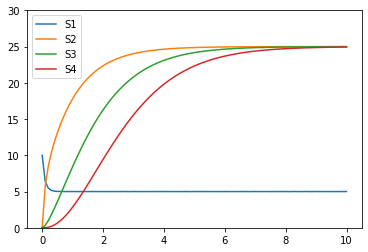

In [28]:
size = 101
times = np.array([n*0.1 for n in range(size)])
result = control.input_output_response(closed, times, X0=X0)
#t, y = control.input_output_response(tellurium, times, U, X0)
df = pd.DataFrame(np.transpose(result.states), columns=nonlinear_sys.state_names)
plt.plot(result.t, df)
plt.legend(df.columns)
plt.ylim([0, 30])

# Predatory Prey

## Original Model

In [ ]:
def predprey_rhs(t, x, u, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x[0]
    L = x[1]

    # Compute the control action (only allow addition of food)
    u_0 = u if u > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

In [ ]:
io_predprey = control.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

In [ ]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(io_predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

In [ ]:
np.shape(T)

In [ ]:
# Create a feedback controller. Step 1: Find an equalibrium point
eqpt = control.find_eqpt(io_predprey, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_predprey = control.linearize(io_predprey, xeq, 0)

In [ ]:
# Step 2: Construct the controller via pole placement
K = control.place(lin_predprey.A, lin_predprey.B, [-0.1, -0.2])
A, B = lin_predprey.A, lin_predprey.B
C = np.array([[0, 1]])                # regulated output = number of lynxes
kf = -1/(C @ np.linalg.inv(A - B @ K) @ B)

In [ ]:
# Construct the controller
io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xeq) + kf * (u[0] - xeq[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

# Create the closed loop system
io_closed = control.interconnect(
  [io_predprey, io_controller],       # systems
  connections=[
    ['predprey.u', 'control.y[0]'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]']
)

# Simulate the system
t, y = control.input_output_response(io_closed, T, 30, [15, 20])

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['input'])
plt.show(block=False)

## Disturbance

In [ ]:
# Add a distrubance
disturbance = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: 0 if (t < 20 or t >= 25) else 2, inputs=0,
  outputs='out', name='disturbance')

# Create the closed loop system
io_closed_disturbance = control.interconnect(
  [io_predprey, io_controller, disturbance],       # systems
  connections=[
    ['predprey.u', 'control.y[0]', 'disturbance.out'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]', 'disturbance.out']
)

# Simulate the system
results = control.input_output_response(io_closed_disturbance, T, 30, [15, 20])
outputs = results.outputs
times  = results.t

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(times, outputs[0])
plt.plot(times, outputs[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(times, outputs[2])
plt.plot(times, outputs[3])
plt.legend(['input', 'disturbance'])
plt.show(block=False)

# BioModels 823

In [13]:
ctlsb_823 = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml")

In [ ]:
sys_823 = ctl.NonlinearIOSystem("sys_823", ctlsb_823)

In [ ]:
df.head()

In [ ]:
def plotBiomodel(name, url, is_plot=True):
    ctlsb = ctl.ControlSBML(url)
    sys = ctl.NonlinearIOSystem(name, ctlsb)
    times = [0.1*n for n in range(0, 51)]
    results = control.input_output_response(sys, times, X0=sys.getStateSer().values)
    df = pd.DataFrame(np.transpose(results.states), columns=sys.state_names)
    _, ax = plt.subplots(1)
    _ = ax.plot(results.t, df)
    ax.set_title(name)
    ax.legend(df.columns)
    if not is_plot:
        plt.close()
    
# Tests
plotBiomodel("823", "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml",
            is_plot=False)

In [ ]:
URL_DCT = {
    816: "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000816.5?filename=model.xml",
    823: "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml",
    640: "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000640.2?filename=BIOMD0000000640_url.xml",
    206: "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml",
    861: "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000861.2?filename=Bachmann2011.xml",
}

In [ ]:
for key, value in URL_DCT.items():
    print(key)
    plotBiomodel(str(key), value)